## Importing stuff

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/josephgrovers/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/josephgrovers/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# import numpy, pandas, seaborn, matplotlib just because
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import stem
from nltk.stem import WordNetLemmatizer

# imports needed and set up logging
import gzip
import gensim 
import logging

from gensim.models import Word2Vec


import re
from wordcloud import WordCloud

import pickle

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Cleaning / Pre-processing

### Column work

In [3]:
# Remove nonsense columns and rename relevant ones
data = pd.read_csv("spam.csv", encoding = "latin-1")

In [4]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
data = data[['v1', 'v2']]
data = data.rename(columns = {'v1': 'label', 'v2': 'text'})

In [6]:
# Add message length column
data['original_length'] = data['text'].apply(len)

In [7]:
# Change spam/ham labels to be numerical
data['label']=data['label'].replace({'ham':0,'spam':1})

### Let's check out how our data looks

In [8]:
data.head()

,label,text,original_length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


**Example 1**

In [9]:
data['text'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

**Example 2. Some of the messages have "& lt;#& gt;" in them. Seems to be an error in the text.**

In [10]:
data['text'][5559]

"if you aren't here in the next  &lt;#&gt;  hours imma flip my shit"

### Time to actually clean

In [11]:
def clean_text(text):
    # remove symbols
    text = re.sub('[^a-zA-Z]', ' ', text)  
    # make lowercase
    text = text.lower()  
    
    # split text by spaces / tokenize
    text = text.split(' ')
    # remove stop words from word lists
    # text = [w for w in text if not w in set(stopwords.words('english'))] 
    # remove empty strings in lists
    text = [w for w in text if w != ""]
    # remove 'lt' strings in lists
    text = [w for w in text if w != "lt"]
    # remove 'gt' strings in lists
    text = [w for w in text if w != "gt"]
    # re-gather word lists back into messages! (For Word2Vec, we want to keep it tokenized)
    # text = ' '.join(text)
    
    return text

In [12]:
def tokenize(text):
    # split text by spaces / tokenize
    text = text.split(' ')
    return text

In [13]:
def untokenize(text):
    # re-gather word lists back into messages!
    text = ' '.join(text)
    return text

In [14]:
def remove_stop(text):
    # remove stop words from word lists
    text = [w for w in text if not w in set(stopwords.words('english'))]
    return text

In [15]:
# This takes ~17 seconds
data['text'] = data['text'].apply(lambda x : clean_text(x))

In [16]:
data['text'][2]

['free',
 'entry',
 'in',
 'a',
 'wkly',
 'comp',
 'to',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 'st',
 'may',
 'text',
 'fa',
 'to',
 'to',
 'receive',
 'entry',
 'question',
 'std',
 'txt',
 'rate',
 't',
 'c',
 's',
 'apply',
 'over',
 's']

In [17]:
data['text'][5559]

['if',
 'you',
 'aren',
 't',
 'here',
 'in',
 'the',
 'next',
 'hours',
 'imma',
 'flip',
 'my',
 'shit']

In [18]:
data.head()

,label,text,original_length
0,0,"[go, until, jurong, point, crazy, available, o...",111
1,0,"[ok, lar, joking, wif, u, oni]",29
2,1,"[free, entry, in, a, wkly, comp, to, win, fa, ...",155
3,0,"[u, dun, say, so, early, hor, u, c, already, t...",49
4,0,"[nah, i, don, t, think, he, goes, to, usf, he,...",61


### Pickle

In [19]:
# with open('data_spam.pkl', 'wb') as pickle_file:
#     pickle.dump(data, pickle_file)

In [20]:
# with open('data_spam.pkl', 'rb') as pickle_file:
#     data = pickle.load(pickle_file)

# EDA

## Let's see how much spam we have...

In [21]:
data['label'].value_counts()

0    4825
1     747
Name: label, dtype: int64

In [22]:
747/5572

0.13406317300789664

## Time to make some figures

Text(0, 0.5, 'Frequency')

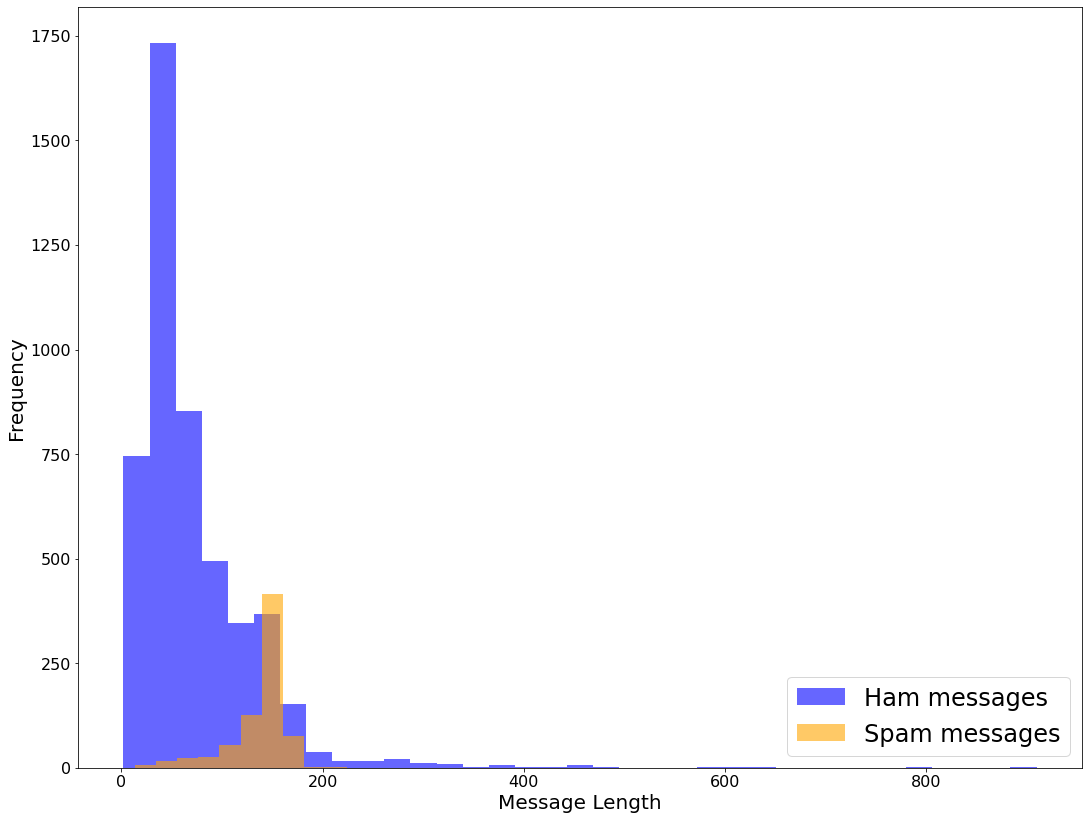

In [75]:
plt.figure(figsize=(18, 14))

data[data['label']==0].original_length.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6, fontsize = 16)
data[data['label']==1].original_length.plot(kind='hist', color='orange', 
                                       label='Spam messages', alpha=0.6, fontsize = 16)

plt.legend(fontsize=24, loc = 4)
plt.xlabel("Message Length", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)

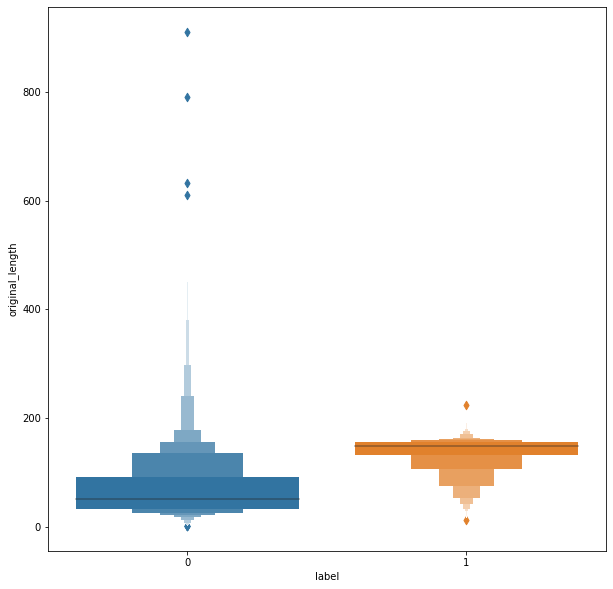

In [61]:
# relation between spam messages and length

plt.rcParams['figure.figsize'] = (10, 10)
sns.boxenplot(x = data['label'], y = data['original_length'])
plt.show()

## Word Clouds

I'll untokenize and retokenize in this section since the wordclouds 

In [25]:
data['text_no_stop'] = data['text']

In [26]:
data['text_no_stop'] = data['text_no_stop'].apply(lambda x : remove_stop(x))

In [27]:
data['text_no_stop'] = data['text_no_stop'].apply(lambda x : untokenize(x))

In [28]:
data.head()

,label,text,original_length,text_no_stop
0,0,"[go, until, jurong, point, crazy, available, o...",111,go jurong point crazy available bugis n great ...
1,0,"[ok, lar, joking, wif, u, oni]",29,ok lar joking wif u oni
2,1,"[free, entry, in, a, wkly, comp, to, win, fa, ...",155,free entry wkly comp win fa cup final tkts st ...
3,0,"[u, dun, say, so, early, hor, u, c, already, t...",49,u dun say early hor u c already say
4,0,"[nah, i, don, t, think, he, goes, to, usf, he,...",61,nah think goes usf lives around though


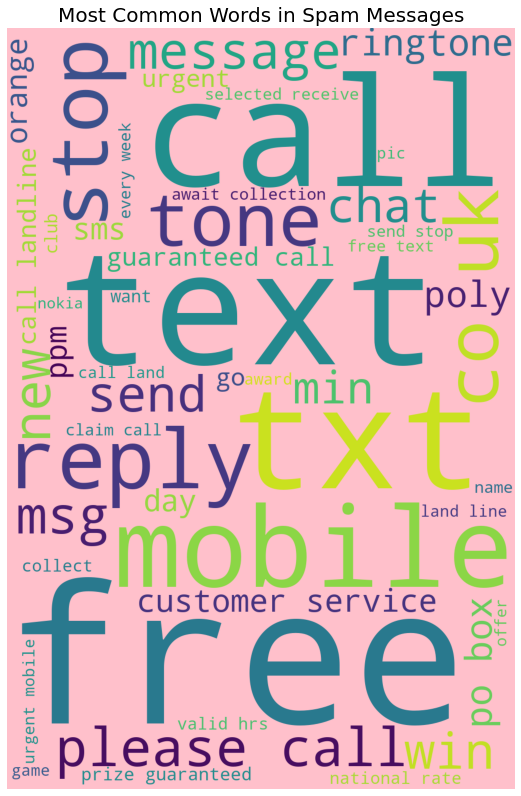

In [29]:
# checking the most common words in spam messages
spam = ' '.join(text for text in data['text_no_stop'][data['label'] == 1])

wordcloud = WordCloud(background_color = 'pink', max_words = 50, height = 1500, width = 1000).generate(spam)

plt.axis('off')
plt.title('Most Common Words in Spam Messages', fontsize = 20)
plt.imshow(wordcloud);

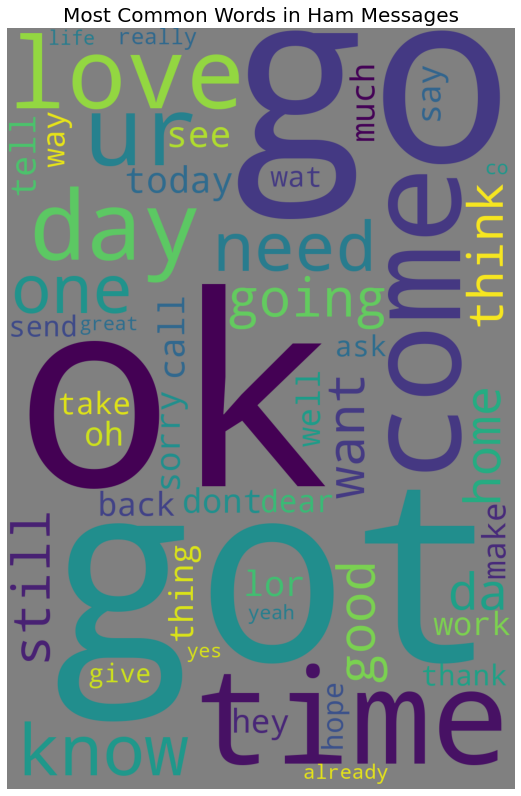

In [30]:
ham = ' '.join(text for text in data['text_no_stop'][data['label'] == 0])

wordcloud = WordCloud(background_color = 'gray', max_words = 50, height = 1500, width = 1000).generate(ham)

plt.axis('off')
plt.title('Most Common Words in Ham Messages', fontsize = 20)
plt.imshow(wordcloud);

## Popular word counts

In [31]:
from collections import Counter

In [32]:
words = data[data.label==0].text_no_stop.apply(lambda x: [word for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(30))

[('u', 1026), ('get', 311), ('ok', 287), ('go', 253), ('ur', 241), ('know', 236), ('call', 236), ('got', 233), ('good', 233), ('like', 232), ('come', 228), ('day', 216), ('time', 201), ('love', 199), ('going', 169), ('one', 167), ('home', 165), ('want', 165), ('lor', 162), ('need', 158), ('sorry', 157), ('da', 150), ('still', 150), ('k', 145), ('n', 144), ('today', 139), ('see', 139), ('r', 139), ('later', 135), ('dont', 132)]


In [33]:
ham_word_list = ham_words.most_common(30)
ham_word_df = pd.DataFrame(ham_word_list)
ham_word_df = ham_word_df.rename(columns = {0: 'word', 1: 'count'})
ham_word_df = ham_word_df.set_index('word')

In [34]:
words = data[data.label==1].text_no_stop.apply(lambda x: [word for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(30))

[('call', 370), ('free', 228), ('u', 186), ('p', 180), ('txt', 170), ('ur', 144), ('mobile', 129), ('text', 126), ('stop', 126), ('claim', 113), ('reply', 104), ('www', 98), ('prize', 93), ('get', 86), ('cash', 76), ('uk', 74), ('win', 72), ('nokia', 71), ('send', 70), ('new', 69), ('c', 63), ('urgent', 63), ('week', 60), ('tone', 60), ('com', 59), ('box', 57), ('msg', 56), ('service', 56), ('contact', 56), ('please', 55)]


In [35]:
spam_word_list = spam_words.most_common(30)
spam_word_df = pd.DataFrame(spam_word_list)
spam_word_df = spam_word_df.rename(columns = {0: 'word', 1: 'count'})
spam_word_df = spam_word_df.set_index('word')

In [36]:
# # Check the dataframes
ham_word_df.head()
# spam_word_df.head()

,count
word,
u,1026
get,311
ok,287
go,253
ur,241


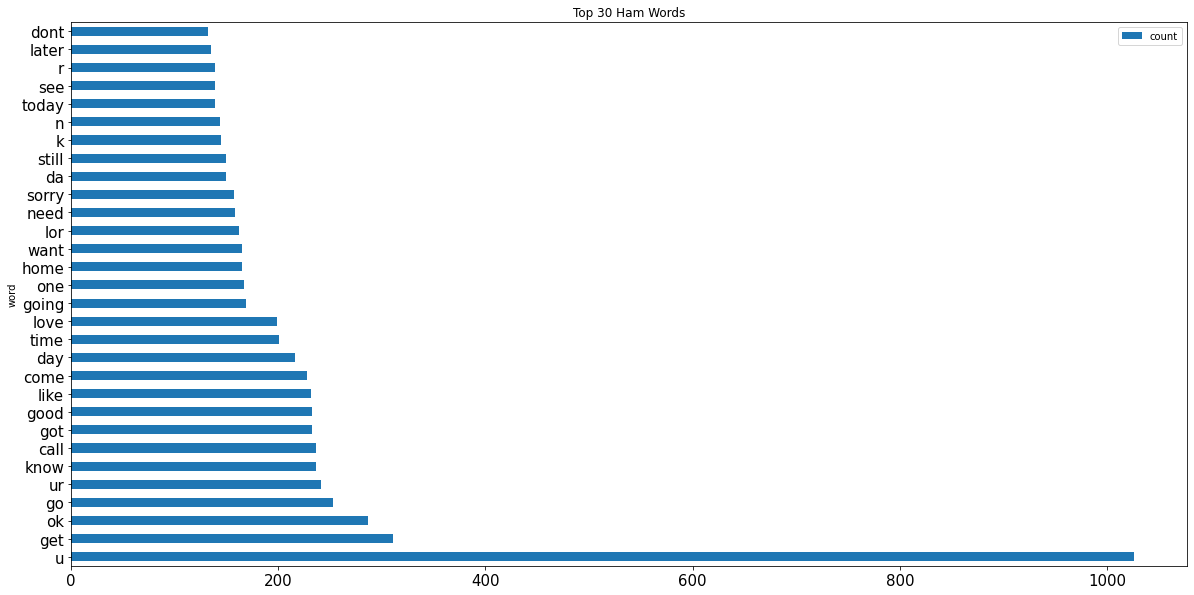

In [37]:
ham_word_df.plot(kind='barh', figsize=(20,10), title = 'Top 30 Ham Words', fontsize = 15);

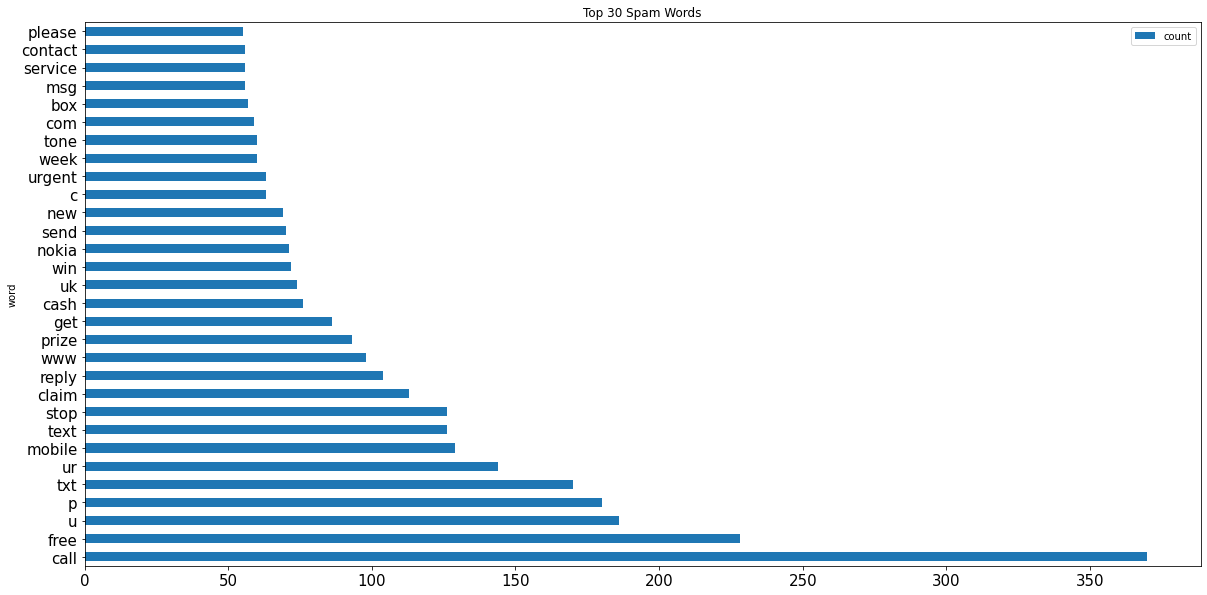

In [38]:
spam_word_df.plot(kind='barh', figsize=(20,10), title = 'Top 30 Spam Words', fontsize = 15);

In [39]:
#re-tokenize
data['text_no_stop'] = data['text_no_stop'].apply(lambda x : tokenize(x))

# Word2Vec

### Develop Word2Vec Embedding

In [40]:
sentences = data['text']
model = gensim.models.Word2Vec (sentences) # (sentences, size=100, window=10, min_count=2, workers=10)
words = list(model.wv.vocab)

In [41]:
# # print learned vocabulary as tokens
# print(words)

In [42]:
# # review embedded vector
# print(model['go'])

In [43]:
words[:10]

['go',
 'until',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'n',
 'great']

^^ seems like we're moving in the right direction

#### Save and load data

In [44]:
# # save data
# model.wv.save_word2vec_format('model.bin')

In [45]:
# # load data
# model = Word2Vec.load('model.bin')

---

## Visualize Embedding

In [46]:
X = model[model.wv.vocab]

### Plot Word Vectors Using PCA

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)

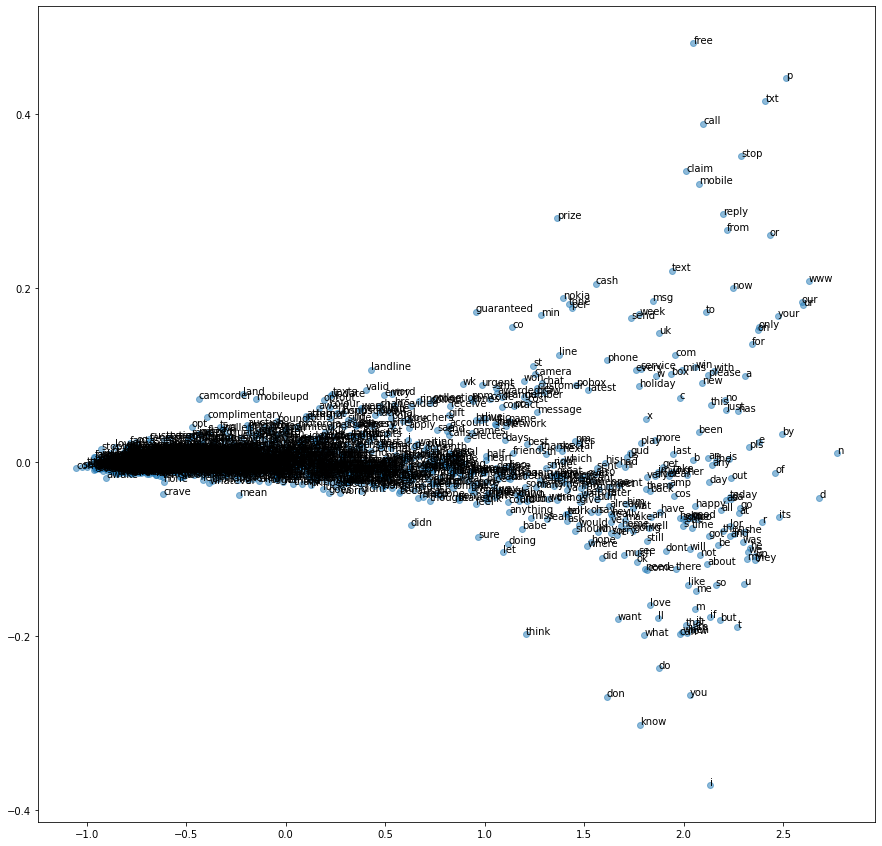

In [48]:
plt.figure(figsize=(15,15))
plt.scatter(result[:, 0], result[:, 1], alpha=.5)
words = list(model.wv.vocab) #uncomment for data labels
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

^^ what a mess

## Trying to train a model myself?

In [49]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [50]:
model.train(sentences,total_examples=len(sentences),epochs=10)

2020-08-21 01:03:19,288 : WARNING : Effective 'alpha' higher than previous training cycles
2020-08-21 01:03:19,290 : INFO : training model with 3 workers on 1798 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2020-08-21 01:03:19,357 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-21 01:03:19,360 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-21 01:03:19,363 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-21 01:03:19,364 : INFO : EPOCH - 1 : training on 86225 raw words (58018 effective words) took 0.1s, 947946 effective words/s
2020-08-21 01:03:19,431 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-21 01:03:19,439 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-21 01:03:19,439 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-21 01:03:19,440 : INFO : EPOCH - 2 : training on 86225 raw words (58015 e

(580703, 862250)

In [51]:
w1 = "free"
model.wv.most_similar (positive=w1)

2020-08-21 01:03:19,992 : INFO : precomputing L2-norms of word weight vectors


[('colour', 0.9675248265266418),
 ('nokia', 0.9395715594291687),
 ('latest', 0.9353546500205994),
 ('ringtone', 0.9338977336883545),
 ('video', 0.9264539480209351),
 ('update', 0.9218356609344482),
 ('mins', 0.9218213558197021),
 ('tariffs', 0.9179341793060303),
 ('phones', 0.9179338812828064),
 ('reply', 0.9176622629165649)]

In [52]:
# look up top 6 words similar to 'call'
w1 = ["call"]
model.wv.most_similar (positive=w1,topn=6)

[('code', 0.8889859318733215),
 ('expires', 0.8768417835235596),
 ('quoting', 0.8732936382293701),
 ('landline', 0.8661541938781738),
 ('identifier', 0.8652039766311646),
 ('mobileupd', 0.8488324880599976)]

In [53]:
# look up top 6 words similar to 'text'
w1 = ["text"]
model.wv.most_similar (positive=w1,topn=6)

[('help', 0.8975965976715088),
 ('reply', 0.8791678547859192),
 ('charged', 0.8601633310317993),
 ('chat', 0.841383695602417),
 ('offers', 0.8204718828201294),
 ('live', 0.8175668120384216)]

In [54]:
# look up top 6 words similar to 'txt'
w1 = ["txt"]
model.wv.most_similar (positive=w1,topn=6)

[('www', 0.9525451064109802),
 ('sms', 0.9481164813041687),
 ('com', 0.947150707244873),
 ('stop', 0.9378734827041626),
 ('uk', 0.9344052076339722),
 ('word', 0.9336037635803223)]

#### Let's check over word similarities

In [55]:
# similarity between two different words, should match above
model.wv.similarity(w1="txt",w2="www")

0.952545

^ Awesome. It looks good.

In [56]:
# similarity between two different words
model.wv.similarity(w1="mobile",w2="free")

0.90967333

In [57]:
# similarity between two different words
model.wv.similarity(w1="ok",w2="free")

-0.11221653

^ These two look about right.

In [58]:
# Which one is the odd one out in this list? 
model.wv.doesnt_match(["hi","ok","mobile"])

'ok'

In [59]:
# Which one is the odd one out in this list? 
model.wv.doesnt_match(["hi","free","mobile"])

'hi'

^ Looks correct according to the word cloud popularity between ham/spam